# Multi Agent Systems

## General Imports

In [1]:
from scipy.interpolate import interp1d

import hashlib
import matplotlib.pyplot as plt
import numpy as np

## Agents

In [2]:
class Bot:
    def __init__(self, rounds, players, bal_per_round, init_balance, first_price):
        self.first_price = first_price
        self.init_balance = init_balance
        self.balance = init_balance
        self.rounds = rounds
        self.opponents = players - 1
        self.bal_per_round = bal_per_round
        self.curr_round = -1
        self.avg_balance = init_balance / rounds
        self.bidding_power = 0

    def pre_round(self, winner, win_amount):
        self.curr_round += 1
        self.balance += self.bal_per_round
        self.bidding_power += self.avg_balance
        
        if winner == 0:
            self.balance -= win_amount
            self.bidding_power -= win_amount
        if self.bidding_power < 0:
            self.bidding_power = 0

    def play_round(self, winner, win_amount):
        pass

In [3]:
class BigBidderBot(Bot):
    def play_round(self, winner, win_amount):
        super().pre_round(winner, win_amount)
        # the agent bids all his current money or all his bidding power
        # depending on the type of auction
        return self.balance if self.init_balance == 0 else self.bidding_power

In [4]:
class RandomBot(Bot):
    def play_round(self, winner, win_amount):
        super().pre_round(winner, win_amount)
        # if the agent is given a specific amount of money each round
        if self.init_balance == 0:
            # he bids a random amount of money depending on his current balance
            return np.random.randint(0, self.balance)
        # if the agent is given an initial balance
        else:
            # he bids a random amount of money depending on his current bidding power
            return np.random.randint(0, self.bidding_power)

In [5]:
class CopycatBot(Bot):
    def play_round(self, winner, win_amount):
        super().pre_round(winner, win_amount)
        # if the agent has as much money as the amount of money paid by the previous winner
        # the agent bids the same amount
        if win_amount <= self.balance and win_amount <= self.bidding_power and win_amount != -1:
            return win_amount
        # else he bids almost all his money or bidding power, actually 80% of it
        else:
            return self.balance * 0.8 if self.init_balance == 0 else self.bidding_power * 0.8

In [6]:
class PercentageBot(Bot):
    def play_round(self, winner, win_amount):
        super().pre_round(winner, win_amount)
        # if the agent lost on the previous round or no one won
        # he will have more money this round so he can save some and bid only 60%
        # of his total or of his bidding power
        if winner > 0:
            return self.balance * 0.6 if self.init_balance == 0 else self.bidding_power * 0.6
        # if he won
        # he will probably have less money so he must bid almost all his money to win
        else:
            return self.balance * 0.8 if self.init_balance == 0 else self.bidding_power * 0.8

In [7]:
class CounterBot(Bot):
    def __init__(self, rounds, players, bal_per_round, init_balance, first_price):
        super().__init__(rounds, players, bal_per_round, init_balance, first_price)
        self.opps = [0] * (players - 1)

    def play_round(self, winner, win_amount):
        super().pre_round(winner, win_amount)
        
        # decide the unit based on whether the auction is based
        # on a given balance per round or on an initial balance
        unit = self.bal_per_round if self.bal_per_round else self.avg_balance
        
        # update the opponents' balance (in approximation
        # for auctions with an initial balance)
        for opp in range(self.opponents):
            self.opps[opp] += unit
        
        # update the winner's balance
        if winner > 0:
            winner -= 1  # convert to index value
            if win_amount <= self.opps[winner]:
                self.opps[winner] -= win_amount
            else:
                self.opps[winner] = 0
        
        # set an upper limit for the bid
        max_bid = self.balance if self.bal_per_round else self.bidding_power
        
        # calculate the bid that counters the opponents
        for bid in sorted(self.opps, reverse=True):
            if bid < max_bid:
                return bid + 1
        
        # if we can't beat the opponents, bid our max value
        return max_bid

In [8]:
class AverageBot(Bot):
    def __init__(self, rounds, players, bal_per_round, init_balance, first_price):
        super().__init__(rounds, players, bal_per_round, init_balance, first_price)
        self.number = 0
        self.memory = 0

    def play_round(self, winner, win_amount):
        super().pre_round(winner, win_amount)
        # if the agent is given a specific amount of money each round
        if self.init_balance == 0:
            unit = self.balance
        # if the agent is given an initial balance
        else:
            unit = self.bidding_power         
        # if there is a valid bid count it
        if win_amount>0:
            self.number = self.number + 1
            self.memory = self.memory + win_amount
        bid = 0
        # if the balance is lower than 70% of the initial balance per round, then we don't have much money
        if unit <= self.bal_per_round*0.7:
            # so we bid 50% of our balance to keep some money and have at least a small chance at winning
            bid = unit*0.5
        # if the balance is higher than 70% of the initial balance per round
        elif win_amount > 0:
            # we bid the average of every winning amount until the current round
            bid = self.memory/self.number
        # if the auction type is Second Price
        if self.first_price == False:
            # the average calculated will not be accurate (it will be from the winning amount, the second biggest)
            # and we increase it by 80% so the agent will be competitive
            bid = bid + bid*0.8
        # if the average is higher than our balance
        if bid > unit:
            # we bid all of our balance
             bid = unit
        return round(bid)

In [9]:
class EvenBot(Bot):
    def play_round(self, winner, win_amount):
        super().pre_round(winner, win_amount)
        if self.curr_round % 2 != 0 or self.curr_round==(self.rounds-1):
            return self.balance if self.init_balance == 0 else self.bidding_power
        else:
            return 1

In [10]:
class WinningStreakBot(Bot):
    def play_round(self, winner, win_amount):
        super().pre_round(winner, win_amount)
        # The agent get money at the beggining of each round
        if self.init_balance==0:
            # If the agent won the last round, keep on trying to win
            if winner == 0 or winner == -1:
                return self.balance
            else:
                # If you can pay the last win amount + 1
                if self.balance > win_amount + 1:
                    return win_amount + 1
                # If not, dont try to bid, accumulate budget
                else:
                    return 0

        # The agent starts with a balance
        else:
            # If the agent won the last round, keep on trying to win
            # but maintain a balance by using bidding_power
            if winner == 0 or winner == -1:
                return self.bidding_power
            else:
                # If you can pay the last win amount + 1
                if self.bidding_power > win_amount + 1:
                    return win_amount + 1
                # If not, dont try to bid, accumulate budget
                else:
                    return 0

In [11]:
class AvoidLosingBot(Bot):
    def play_round(self, winner, win_amount):
        super().pre_round(winner, win_amount)
        # The agent get money at the beggining of each round
        if self.init_balance==0:
            # If the agent lost the last round,
            # attempt to take back the winning status
            if winner != 0 or winner == -1:
                return self.balance
            else:
                # If you can pay the last win amount + 1
                if self.balance > win_amount + 1:
                    return win_amount + 1
                # If not, dont try to bid, accumulate budget
                else:
                    return 0

        # The agent starts with a balance
        else:
            # If the agent lost the last round, attemt to take back
            # the winning status but maintain a balance by using bidding_power
            if winner != 0 or winner == -1:
                return self.bidding_power
            else:
                # If you can pay the last win amount + 1
                if self.bidding_power > win_amount + 1:
                    return win_amount + 1
                # If not, dont try to bid, accumulate budget
                else:
                    return 0

## Util Classes

In [12]:
class Bid:
    def __init__(self, index, amount):
        self.index = index
        self.amount = amount

## Auction

In [13]:
def shuffle_order(num_list):
    n = len(num_list)
    hash_index = int(hashlib.sha1(str(num_list).encode()).hexdigest(), 16) % 24
    result = []
    for i in range(n, 0, -1):
        result.append(num_list[hash_index % i])
        del num_list[hash_index % i]
        hash_index //= i
    return result

In [14]:
def auction(bot_list, rounds, bal_per_round, init_balance, first_price):
    N = len(bot_list)
    agent_indexes = shuffle_order(list(range(N)))
    agents = [bot_list[i](rounds, N, bal_per_round, init_balance, first_price) for i in agent_indexes]
    
    score = [0] * N
    total = [0] * N
    balance = [init_balance] * N

    (prev_winner, prev_bid) = (-1, -1)
    for _round in range(rounds):
        bids = []
        for i in range(N):
            balance[i] += bal_per_round

            if prev_winner == i:
                prev_winner = 0
            elif prev_winner != -1 and prev_winner < i:
                prev_winner += 1

            bid = int(agents[i].play_round(prev_winner, prev_bid))
            if bid < 0 or bid > balance[i]:
                name = bot_list[agent_indexes[i]].__name__
                raise ValueError("Agent #%s tried to bid with an invalid amount (%d)" % (name, bid))
            bids.append(Bid(i, bid))

        bids.sort(reverse=True, key= lambda b: b.amount)

        winner = -1
        top_bid = bids[0].amount
        for i in range(1, N):
            if bids[i].amount == top_bid:
                winner = -1
                bids[i].amount = -1
                bids[i - 1].amount = -1
            else:
                if bids[i - 1].amount == -1:
                    winner = i
                    top_bid = bids[i].amount
                else:
                    winner = i - 1
                    break

        if winner == -1:
            (prev_winner, prev_bid) = (-1, -1)
        else: 
            w_bid = bids[winner]
            
            if first_price or len(bids) == winner + 1:
                prev_bid = w_bid.amount
            else:
                prev_bid = bids[winner + 1].amount
                
            prev_winner = w_bid.index
            score[agent_indexes[prev_winner]] += 1
            total[agent_indexes[prev_winner]] += prev_bid
            balance[prev_winner] -= prev_bid

    return score, total

In [15]:
def show_results(score, total):
    results = sorted(map(list, zip(score, total, bot_list)), key= lambda k: (-k[0], k[1]))

    for score, total, agent in results:
        name = agent.__name__
        avg = total / score if score != 0 else 0
        print("%-20s Wins: %-6d Total Spent: %-9d Avg Spent per Win: %.2f" % (name, score, total, avg))

In [16]:
def simulate(bot_list, experiments=10, rounds=10, bal_per_round=0, init_balance=0, first_price=True, print_experiments=False):
    scores = []
    totals = []
    
    for _ in range(experiments):
        (score, total) = auction(bot_list, rounds, bal_per_round, init_balance, first_price)
        scores.append(np.array(score))
        totals.append(np.array(total))
        
        if print_experiments:
            print("End of experiment")
            show_results(score, total)
            print()
    
    print("End of simulation")
    score = sum(scores)
    total = sum(totals)
    show_results(score, total)
    return scores, totals

In [17]:
def interp(y):
    n = len(y)
    x = np.linspace(0, n, n)
    x_new = np.linspace(0, n, 4 * n + 1)
    f = interp1d(x, y, kind="cubic")
    return x_new, f(x_new)

def moving_avg(timeseries, window):
    return np.convolve(timeseries, np.ones(window), "valid") / window

In [18]:
def plot_experiments(bot_list, experiments, scores):
    cumulative_scores = np.cumsum(scores, axis=0)
    
    results = []
    for i in range(len(bot_list)):
        score_per_bot = []
        for j in range(experiments):
            score_per_bot.append(scores[j][i])
        results.append(score_per_bot)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,12))
    for i in range(len(results)):
        xy1 = interp(results[i])
        xy2 = interp(moving_avg(results[i], 3))
        ax1.plot(xy1[0], xy1[1], label=bot_list[i].__name__)
        ax2.plot(xy2[0], xy2[1], label=bot_list[i].__name__)
    
    ax1.set_title('Wins per experiment')
    ax2.set_title('Wins per experiment (moving average, window=3)')

    for axs in (ax1, ax2):
        axs.set_xlabel('Experiment number')
        axs.set_ylabel('Wins')
        axs.legend(loc='lower left')
        axs.grid()

## Experiments

In [19]:
(experiments, rounds) = (25, 365)
(init_balance, bal_per_round) = (50000, 500)

bot_list = [
    # add bots from previous blocks
    PercentageBot,
    CounterBot,
    AverageBot,
    CopycatBot,
    EvenBot,
    WinningStreakBot,
    AvoidLosingBot,
#     BigBidderBot,
    RandomBot,
]

### First Price Auction with initial balance

End of simulation
AverageBot           Wins: 1205   Total Spent: 1232636   Avg Spent per Win: 1022.93
CounterBot           Wins: 1197   Total Spent: 1235301   Avg Spent per Win: 1032.00
PercentageBot        Wins: 1171   Total Spent: 1221423   Avg Spent per Win: 1043.06
AvoidLosingBot       Wins: 1164   Total Spent: 1239038   Avg Spent per Win: 1064.47
WinningStreakBot     Wins: 1146   Total Spent: 1234871   Avg Spent per Win: 1077.55
CopycatBot           Wins: 1141   Total Spent: 1233144   Avg Spent per Win: 1080.76
EvenBot              Wins: 1103   Total Spent: 1238763   Avg Spent per Win: 1123.09
RandomBot            Wins: 998    Total Spent: 1227915   Avg Spent per Win: 1230.38


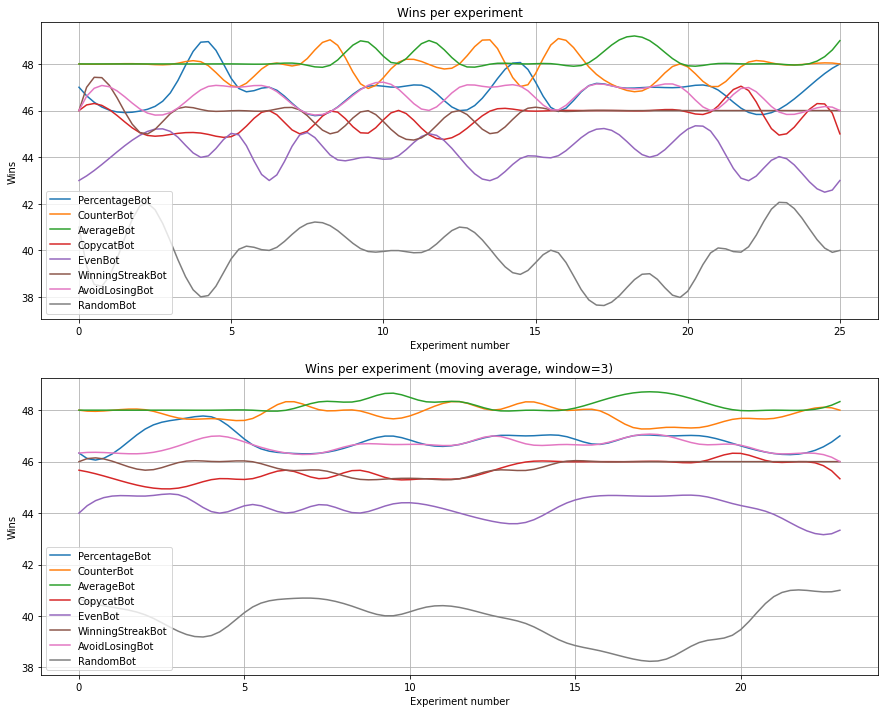

In [20]:
scores, totals = simulate(bot_list, experiments, rounds, init_balance=init_balance)
plot_experiments(bot_list, experiments, scores)

### Second Price Auction with initial balance

End of simulation
CopycatBot           Wins: 1166   Total Spent: 1202684   Avg Spent per Win: 1031.46
PercentageBot        Wins: 1166   Total Spent: 1217247   Avg Spent per Win: 1043.95
AvoidLosingBot       Wins: 1152   Total Spent: 1234894   Avg Spent per Win: 1071.96
RandomBot            Wins: 1140   Total Spent: 1224340   Avg Spent per Win: 1073.98
EvenBot              Wins: 1137   Total Spent: 1231744   Avg Spent per Win: 1083.33
AverageBot           Wins: 1127   Total Spent: 1234472   Avg Spent per Win: 1095.36
WinningStreakBot     Wins: 1122   Total Spent: 1228720   Avg Spent per Win: 1095.12
CounterBot           Wins: 1115   Total Spent: 1233845   Avg Spent per Win: 1106.59


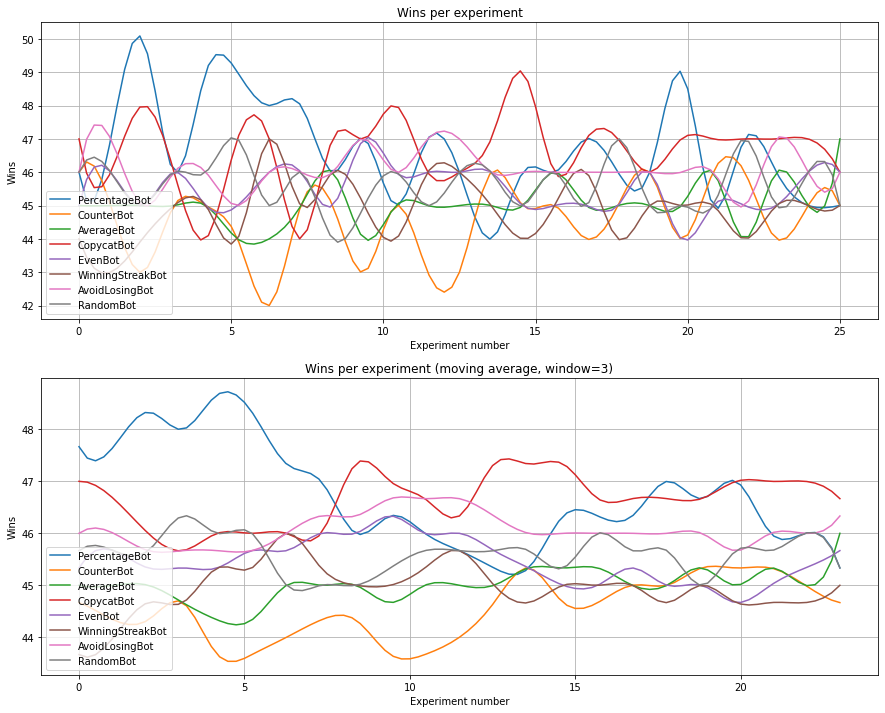

In [22]:
scores, totals = simulate(bot_list, experiments, rounds, init_balance=init_balance, first_price=False)
plot_experiments(bot_list, experiments, scores)

### First Price Auction with given balance per round

End of simulation
AverageBot           Wins: 1202   Total Spent: 4495850   Avg Spent per Win: 3740.31
CounterBot           Wins: 1196   Total Spent: 4512383   Avg Spent per Win: 3772.90
CopycatBot           Wins: 1168   Total Spent: 4494407   Avg Spent per Win: 3847.95
AvoidLosingBot       Wins: 1168   Total Spent: 4520500   Avg Spent per Win: 3870.29
PercentageBot        Wins: 1147   Total Spent: 4448843   Avg Spent per Win: 3878.68
WinningStreakBot     Wins: 1145   Total Spent: 4520190   Avg Spent per Win: 3947.76
EvenBot              Wins: 1097   Total Spent: 4519500   Avg Spent per Win: 4119.87
RandomBot            Wins: 1002   Total Spent: 4487218   Avg Spent per Win: 4478.26


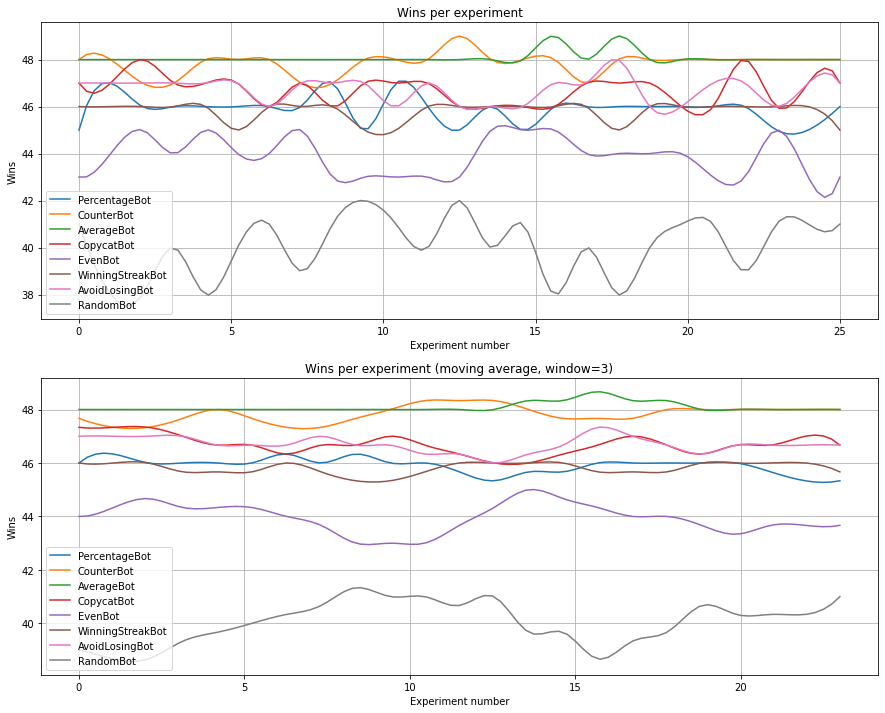

In [23]:
scores, totals = simulate(bot_list, experiments, rounds, bal_per_round=bal_per_round)
plot_experiments(bot_list, experiments, scores)

### Second Price Auction with given balance per round

End of simulation
WinningStreakBot     Wins: 1165   Total Spent: 4468043   Avg Spent per Win: 3835.23
AvoidLosingBot       Wins: 1151   Total Spent: 4518996   Avg Spent per Win: 3926.15
CopycatBot           Wins: 1149   Total Spent: 4473619   Avg Spent per Win: 3893.49
PercentageBot        Wins: 1141   Total Spent: 4429000   Avg Spent per Win: 3881.68
CounterBot           Wins: 1135   Total Spent: 4504274   Avg Spent per Win: 3968.52
AverageBot           Wins: 1131   Total Spent: 4499521   Avg Spent per Win: 3978.36
RandomBot            Wins: 1127   Total Spent: 4475905   Avg Spent per Win: 3971.52
EvenBot              Wins: 1126   Total Spent: 4502086   Avg Spent per Win: 3998.30


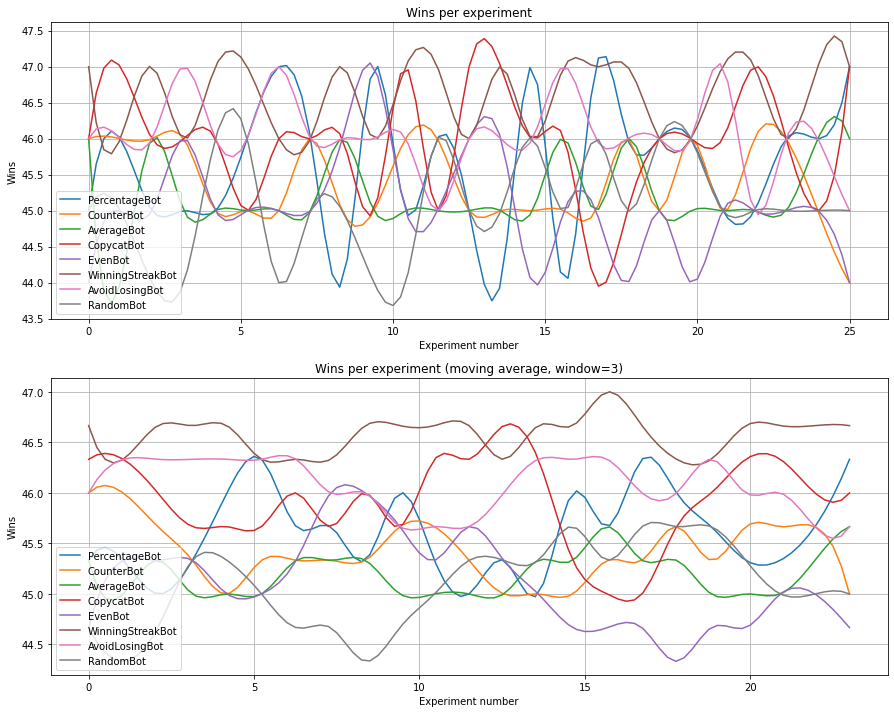

In [24]:
scores, totals = simulate(bot_list, experiments, rounds, bal_per_round=bal_per_round, first_price=False)
plot_experiments(bot_list, experiments, scores)